## 1. Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import deeplake

print(tf.__version__)


2.15.0


d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.12) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


## 2. Load Dataset

In [2]:
ROOT_PATH = "D:/Programming/Projects/Public/plant-lens/ai"
DATASET_DATA_PATH = f"{ROOT_PATH}/data/dataset"

training_dataset = deeplake.load(f'{DATASET_DATA_PATH}/training')
testing_dataset = deeplake.load(f'{DATASET_DATA_PATH}/testing')

training_dataset.summary()
testing_dataset.summary()

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/testing loaded successfully.

Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training', tensors=['images', 'labels'])

 tensor      htype           shape          dtype  compression
 -------    -------         -------        -------  ------- 
 images      image     (224, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (224, 1)       uint16    None   
Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/testing', tensors=['images', 'labels'])

 tensor      htype           shape         dtype  compression
 -------    -------         -------       -------  ------- 
 images      image     (56, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (56, 1)       uint16    None   


In [3]:
data_classes = list(set(sum(training_dataset.labels.data()['text'], [])))
data_classes_count = len(data_classes)
print("Total Number of Classes", data_classes_count)

Total Number of Classes 14


### 2.2 Create Data Pipeline

In [4]:
training_size = int(len(training_dataset.labels) * 0.8)
print("Train Data Size", training_size, "Validation Data Size", len(training_dataset.labels) - training_size)

training_dataset = training_dataset.tensorflow()
testing_dataset = testing_dataset.tensorflow()

validation_dataset = training_dataset.skip(training_size)
training_dataset = training_dataset.take(training_size)

Train Data Size 179 Validation Data Size 45


In [6]:
# Define a preprocessing function
def preprocess_image(args)->tuple:
  image = args['images']
  image = tf.cast(image, tf.float32)
  image = tf.math.divide(image, 255.0)

  label = args['labels']
  label = tf.cast(label, tf.int32)
  label = tf.squeeze(label)

  encoded_label = tf.one_hot(label, depth=data_classes_count)
  return (image, encoded_label)

training_dataset = training_dataset.map(preprocess_image)
validation_dataset = validation_dataset.map(preprocess_image)
testing_dataset = testing_dataset.map(preprocess_image)

# Shuffle and batch the datasets
BATCH_SIZE = 32
training_dataset = training_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
testing_dataset = testing_dataset.batch(BATCH_SIZE)

In [7]:
for images, labels in training_dataset.take(1):
  print("Training Batch images shape:", images.shape)
  print("Training Batch labels shape:", labels.shape)

for images, labels in testing_dataset.take(1):
  print("Testing Batch images shape:", images.shape)
  print("Testing Batch labels shape:", labels.shape)

for images, labels in validation_dataset.take(1):
  print("Validation Batch images shape:", images.shape)
  print("Validation Batch labels shape:", labels.shape)

Training Batch images shape: (32, 224, 224, 3)
Training Batch labels shape: (32, 14)
Testing Batch images shape: (32, 224, 224, 3)
Testing Batch labels shape: (32, 14)
Validation Batch images shape: (32, 224, 224, 3)
Validation Batch labels shape: (32, 14)


## 3. Build Model

In [9]:
from tensorflow.keras import Model, layers, optimizers, models, callbacks
import tensorflow_hub as hub


def build_model():
    dimensions = 224
    input_layer = layers.Input(shape=(dimensions, dimensions, 3))
    feature_extractor = hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5', trainable=True)(input_layer)
    flatten_layer = layers.Flatten()(feature_extractor)
    hidden_layer = layers.Dense(512, activation='relu')(flatten_layer)
    predictions = layers.Dense(data_classes_count, activation='softmax')(hidden_layer)
    model = Model(inputs=input_layer, outputs=predictions)

    LEARNING_RATE = 0.0001
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
   
    return model

DEVELOPMENT_MODEL_PATH = f"{ROOT_PATH}/model/develop"
VERSION_TAG = "0.2.0-46"
BUILD_MODEL = True

if BUILD_MODEL:
  model = build_model()
else:
  model = models.load_model(f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.keras')
  
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1024)              1026552   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 14)                7182      
                                                                 
Total params: 1558534 (5.95 MB)
Trainable params: 1548854 (5.91 MB)
Non-trainable params: 9680 (37.81 KB)
_________________________________________________________________


## 4. Train Model

In [10]:
%%time

EPOCHS = 50
CHECKPOINT_MODEL_PATH = f"{ROOT_PATH}/model/checkpoint/VERSION"

checkpoint_callback = callbacks.ModelCheckpoint(filepath=CHECKPOINT_MODEL_PATH, save_weights_only=True, verbose=1)
# Train the model
history = model.fit(training_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[checkpoint_callback])


Epoch 1/50



      6/Unknown - 16s 398ms/step - loss: 2.9541 - accuracy: 0.0782
Epoch 1: saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\VERSION
6/6 [==============================] - 18s 835ms/step - loss: 2.9541 - accuracy: 0.0782 - val_loss: 3.0306 - val_accuracy: 0.0444
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 2.4490 - accuracy: 0.3296
Epoch 2: saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\VERSION
6/6 [==============================] - 3s 528ms/step - loss: 2.4490 - accuracy: 0.3296 - val_loss: 3.2077 - val_accuracy: 0.0000e+00
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 2.0698 - accuracy: 0.6480
Epoch 3: saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\VERSION
6/6 [==============================] - 3s 546ms/step - loss: 2.0698 - accuracy: 0.6480 - val_loss: 3.3880 - val_accuracy: 0.0000e+00
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 1.

### 4.2 Training Result


initial | Training loss: 2.9541 | Validation Loss: 3.0306 || Training Accuracy: 7.82 % | Validation Accuracy: 4.44 %
 latest | Training loss: 0.2599 | Validation Loss: 6.9922 || Training Accuracy: 99.44 % | Validation Accuracy: 0.00 %


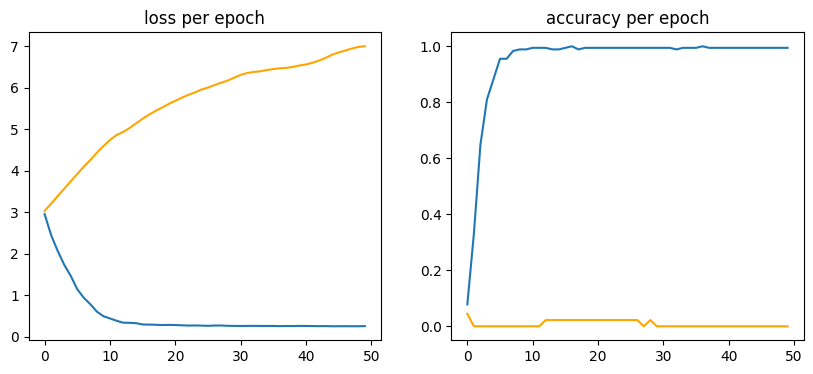

In [11]:
# access metrics from training history
print("\ninitial | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(history.history["loss"][0], history.history["val_loss"][0], history.history["accuracy"][0] * 100, history.history["val_accuracy"][0] * 100))
print(" latest | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(history.history["loss"][-1], history.history["val_loss"][-1], history.history["accuracy"][-1] * 100, history.history["val_accuracy"][-1] * 100))

fig, axis = plt.subplots(1, 2, figsize=(10,4)) 
# plot loss
axis[0].plot(history.history["loss"])
axis[0].plot(history.history["val_loss"], color='orange')
axis[0].set_title("loss per epoch")
# plot accuracy
axis[1].plot(history.history["accuracy"])
axis[1].plot(history.history["val_accuracy"], color='orange')
axis[1].set_title("accuracy per epoch")
plt.show()

## 5. Test Model

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(testing_dataset)

print('Test loss:', test_loss, 'Test accuracy:', test_acc)

2/2 [==============================] - 0s 108ms/step - loss: 2.8098 - accuracy: 0.5357
Test loss: 2.8097589015960693 Test accuracy: 0.5357142686843872


## 6. Visualize Result

2/2 [==============================] - 1s 98ms/step


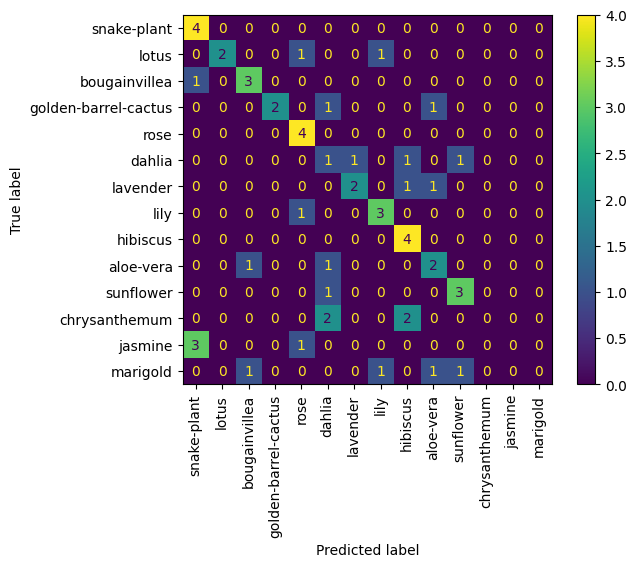

In [13]:
from sklearn import metrics

true_labels = []
for _, labels in testing_dataset:
    true_labels.extend(tf.math.argmax(labels, axis=1).numpy())

predictions = model.predict(testing_dataset)
predicted_labels = tf.math.argmax(predictions, axis=1).numpy()

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=data_classes)

cm_display.plot()

# Rotate x-axis labels by 15 degrees
plt.xticks(rotation=90)
plt.show()

## 7. Save Model

In [16]:
VERSION_TAG = input("Enter Version Tag (e.g 0.0.0):") + f"-{int(test_acc * 100)}" if BUILD_MODEL else VERSION_TAG # "0.0.0"

models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}', save_format="h5")

C:\Users\shirs\AppData\Local\Temp\ipykernel_29620\3946790391.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}', save_format="h5")
